<a href="https://colab.research.google.com/github/Lindronics/honours_project/blob/master/notebooks/classification/hands_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification test 1



## Load dataset

In [1]:
!git clone https://github.com/Lindronics/honours_project_data

Cloning into 'honours_project_data'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 128 (delta 10), reused 124 (delta 9), pack-reused 0
Receiving objects: 100% (128/128), 15.91 MiB | 21.16 MiB/s, done.
Resolving deltas: 100% (10/10), done.


## Data loader

Loads FIR data

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [0]:
from os import listdir
from os import path
import json
import cv2

class HandsDataset(torch.utils.data.Dataset):
    
    def __init__(self, dir):
        with open(path.join(dir, "labels.json"), "r") as f:
            labels = json.load(f)
        self.files, self.labels = zip(*labels.items())
        self.dir = dir

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = path.join(self.dir, "thermal", self.files[idx])

        img = cv2.imread(img_path) / 128 - 1
        img = cv2.resize(img, (128, 128))
        img = np.mean(img, axis=2)[None, ...]

        return {
            "label": self.labels[idx],
            "image": img
        }
        
dataset = HandsDataset("honours_project_data/hands")

In [71]:
dataset[10]

{'image': array([[[-0.77148438, -0.78320312, -0.8046875 , ..., -0.9453125 ,
          -0.9609375 , -0.96875   ],
         [-0.75976562, -0.71386719, -0.77929688, ..., -0.9296875 ,
          -0.9453125 , -0.9609375 ],
         [-0.76074219, -0.74804688, -0.71777344, ..., -0.9375    ,
          -0.95214844, -0.95800781],
         ...,
         [-0.16796875, -0.27441406, -0.29589844, ..., -0.57128906,
          -0.5703125 , -0.54980469],
         [ 0.05078125, -0.11523438, -0.21582031, ..., -0.60839844,
          -0.5703125 , -0.55761719],
         [ 0.32421875,  0.13476562, -0.04296875, ..., -0.4765625 ,
          -0.4765625 , -0.46875   ]]]), 'label': 0}

In [121]:
# Train test split

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(0.2 * dataset_size)

# Shuffle dataset
np.random.seed(100)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

print(train_indices)
print(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=4, sampler=valid_sampler)

[12, 6, 39, 28, 51, 26, 17, 62, 21, 25, 38, 47, 44, 59, 35, 33, 23, 56, 46, 40, 7, 3, 54, 42, 50, 19, 13, 1, 31, 4, 27, 58, 22, 29, 9, 16, 43, 36, 15, 65, 64, 49, 57, 14, 60, 2, 53, 34, 52, 30, 10, 48, 24, 8]
[63, 55, 20, 37, 18, 11, 32, 61, 5, 41, 66, 0, 45]


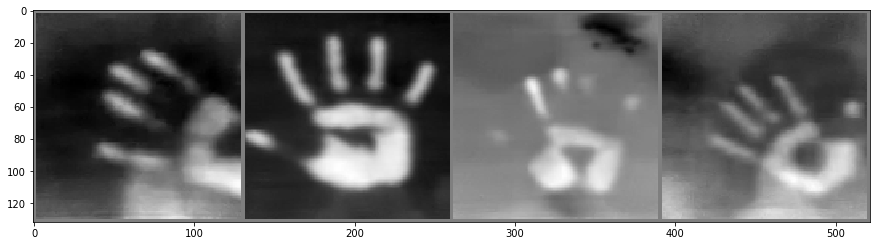

tensor([3, 0, 1, 2])


In [149]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_batch(batch):  
    img, labels = batch["image"], batch["label"]
    imshow(torchvision.utils.make_grid(img))
    print(labels)

dataiter = iter(train_loader)
show_batch(dataiter.next())

## The model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*29*29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*29*29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net = net.float()

In [151]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(70):
    print(f"Starting epoch {epoch}")
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        imgs, labels = data["image"].float(), data["label"]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

Starting epoch 0
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
St

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

all_outputs = []
all_labels = []
for i, data in enumerate(validation_loader, 1000):
    inputs, labels = data["image"].float(), data["label"]
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)
    all_outputs += predicted.tolist()
    all_labels += labels.tolist()

In [155]:
print(classification_report(all_labels, all_outputs))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.50      1.00      0.67         2
           2       0.50      1.00      0.67         2
           3       1.00      0.50      0.67         4

    accuracy                           0.69        13
   macro avg       0.75      0.78      0.69        13
weighted avg       0.85      0.69      0.70        13



[[<matplotlib.axis.YTick at 0x7f947beec978>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')],
 Text(0, 0.5, 'True label'),
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')],
 Text(0.5, 0, 'Predicted label')]

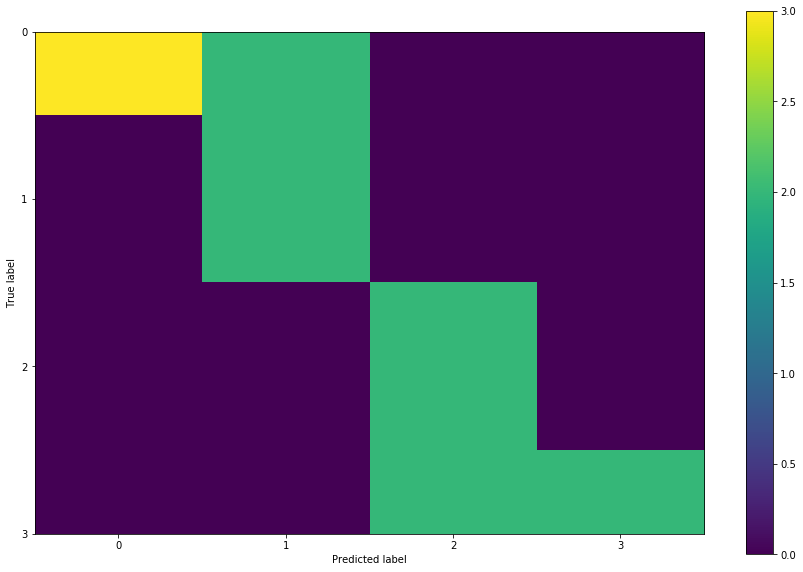

In [160]:
cm = confusion_matrix(all_labels, all_outputs)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=classes, yticklabels=classes,
    ylabel='True label',
    xlabel='Predicted label')